In [3]:
import os
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

## Get and massage portfolio data

In [4]:
ticker_histories_filename = os.path.join("input", "ticker_histories.csv")
ticker_histories_df = pd.read_csv(ticker_histories_filename)
ticker_histories_df["datetime"] = pd.to_datetime(
    ticker_histories_df["timestamp"], unit="ms"
).dt.tz_localize(None)
ticker_histories_df.set_index("datetime", inplace=True)
ticker_histories_df.drop("timestamp", axis=1, inplace=True)
ticker_histories_df.sort_index(inplace=True)
ticker_histories_df

,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2020-04-01 04:00:00,AMZN,96.6485,97.2480,94.6500,95.3850,82437500.0,95.8985,141417
2020-04-01 04:00:00,MSFT,153.0000,157.7500,150.8200,152.1100,57969926.0,153.7717,531817
2020-04-01 04:00:00,AAPL,61.6250,62.1800,59.7825,60.2275,176046552.0,60.9782,460605
2020-04-01 04:00:00,GOOG,56.1000,56.4845,54.8725,55.2810,46883460.0,55.6376,71423
2020-04-01 04:00:00,NVDA,6.3913,6.5383,6.0320,6.0768,656913120.0,6.2836,185913
...,...,...,...,...,...,...,...,...
2025-03-13 04:00:00,AAPL,215.9500,216.8394,208.4200,209.6800,59752532.0,212.0980,768619
2025-03-13 04:00:00,GOOG,167.9800,168.1200,164.0700,164.7300,14841144.0,165.4467,253905
2025-03-13 04:00:00,AMZN,198.1650,198.8799,191.8200,193.8900,39427497.0,194.3506,588340


In [5]:
adj_close_df = ticker_histories_df.reset_index().pivot(
    index="datetime", columns="ticker", values="close"
)
adj_close_df.index = pd.DatetimeIndex(adj_close_df.index)
adj_close_df.index = pd.DatetimeIndex(
    [dt.replace(hour=17, minute=0, second=0) for dt in adj_close_df.index]
)
adj_close_df

ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
2020-04-01 17:00:00,60.2275,95.3850,55.2810,152.11,6.0768,32.1040
2020-04-02 17:00:00,61.2325,95.9415,56.0420,155.26,6.3868,30.2980
2020-04-03 17:00:00,60.3525,95.3295,54.8940,153.83,6.0977,32.0007
2020-04-06 17:00:00,65.6175,99.8795,59.3460,165.27,6.7100,34.4160
2020-04-07 17:00:00,64.8575,100.5800,59.3255,163.49,6.4758,36.3633
...,...,...,...,...,...,...
2025-03-07 17:00:00,239.0700,199.2500,175.7500,393.31,112.6900,262.6700
2025-03-10 17:00:00,227.4800,194.5400,167.8100,380.16,106.9800,222.1500
2025-03-11 17:00:00,220.8400,196.5900,165.9800,380.45,108.7600,230.5800
2025-03-12 17:00:00,216.9800,198.8900,169.0000,383.27,115.7400,248.0900


In [6]:
ticker_decomps = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close = adj_close.asfreq("B", method="ffill")
    components = tsa.seasonal_decompose(adj_close, model="additive")
    adj_close_decomp_df = (
        adj_close.to_frame("original")
        .assign(trend=components.trend)
        .assign(seasonal=components.seasonal)
        .assign(residual=components.resid)
    )
    ticker_decomps[ticker] = adj_close_decomp_df

## Plot the trends for each ticker

In [11]:
def plot_decomp(df, title):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title("Original")
    axs[1].plot(df["trend"], color="orange")
    axs[1].set_title("Trend")
    axs[2].plot(df["seasonal"], color="green")
    axs[2].set_title("Seasonal")
    axs[3].plot(df["residual"], color="red")
    axs[3].set_title("Residual")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

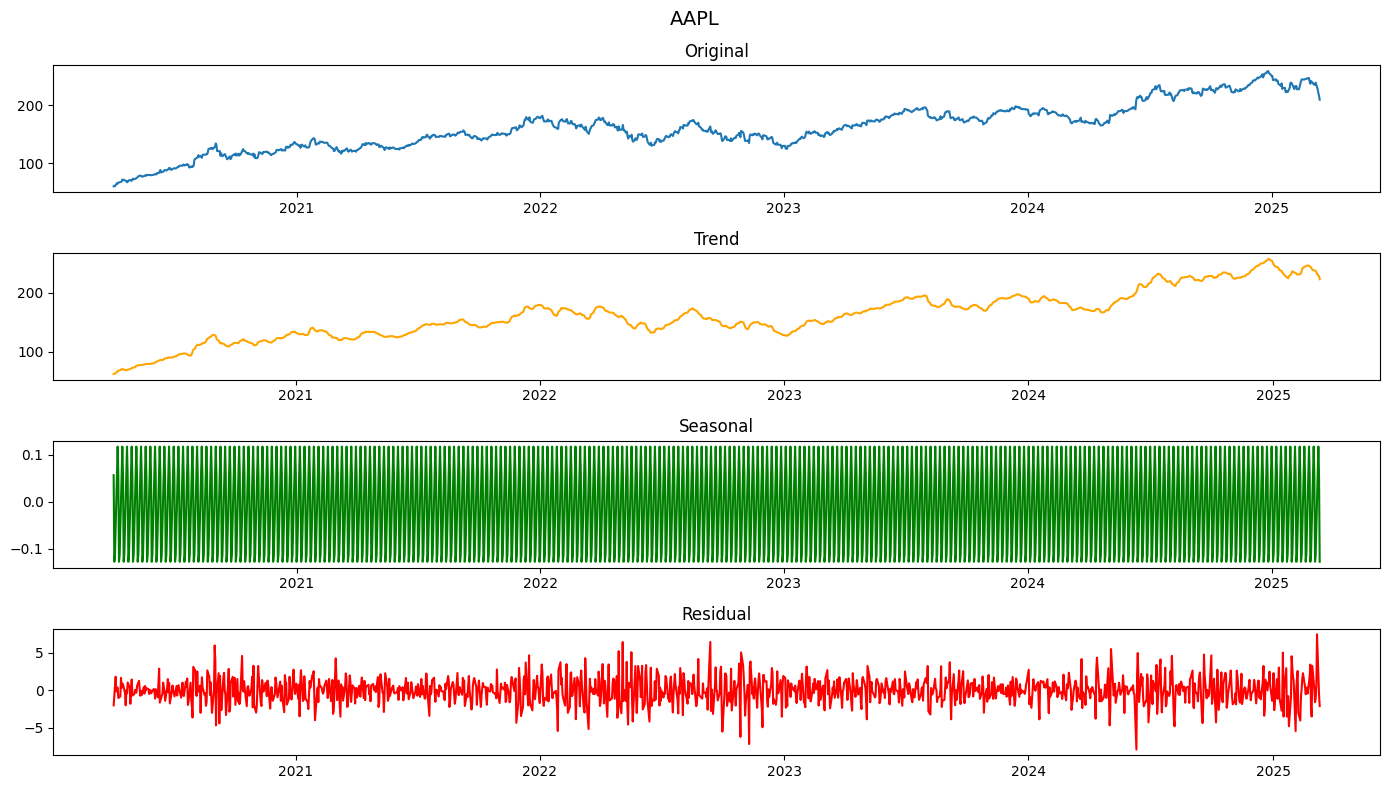

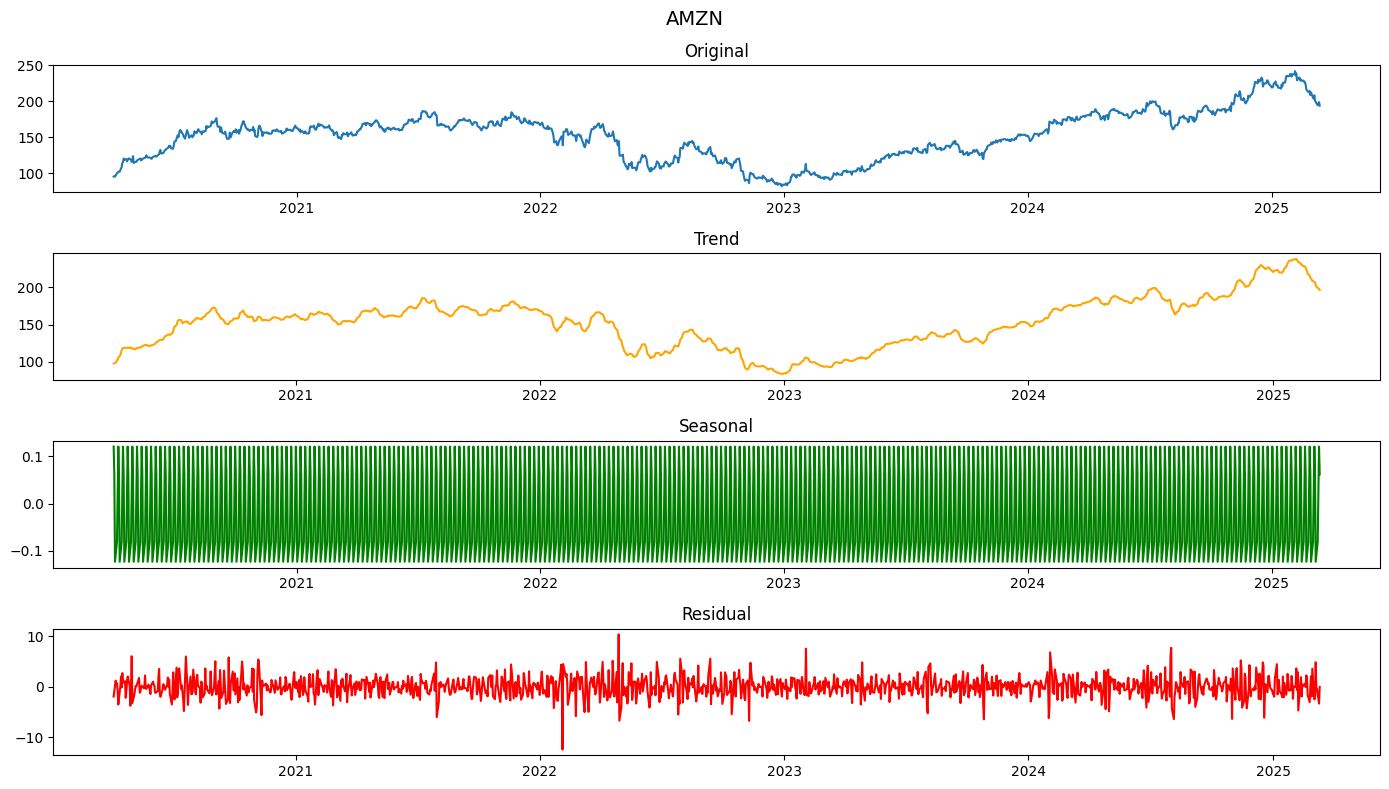

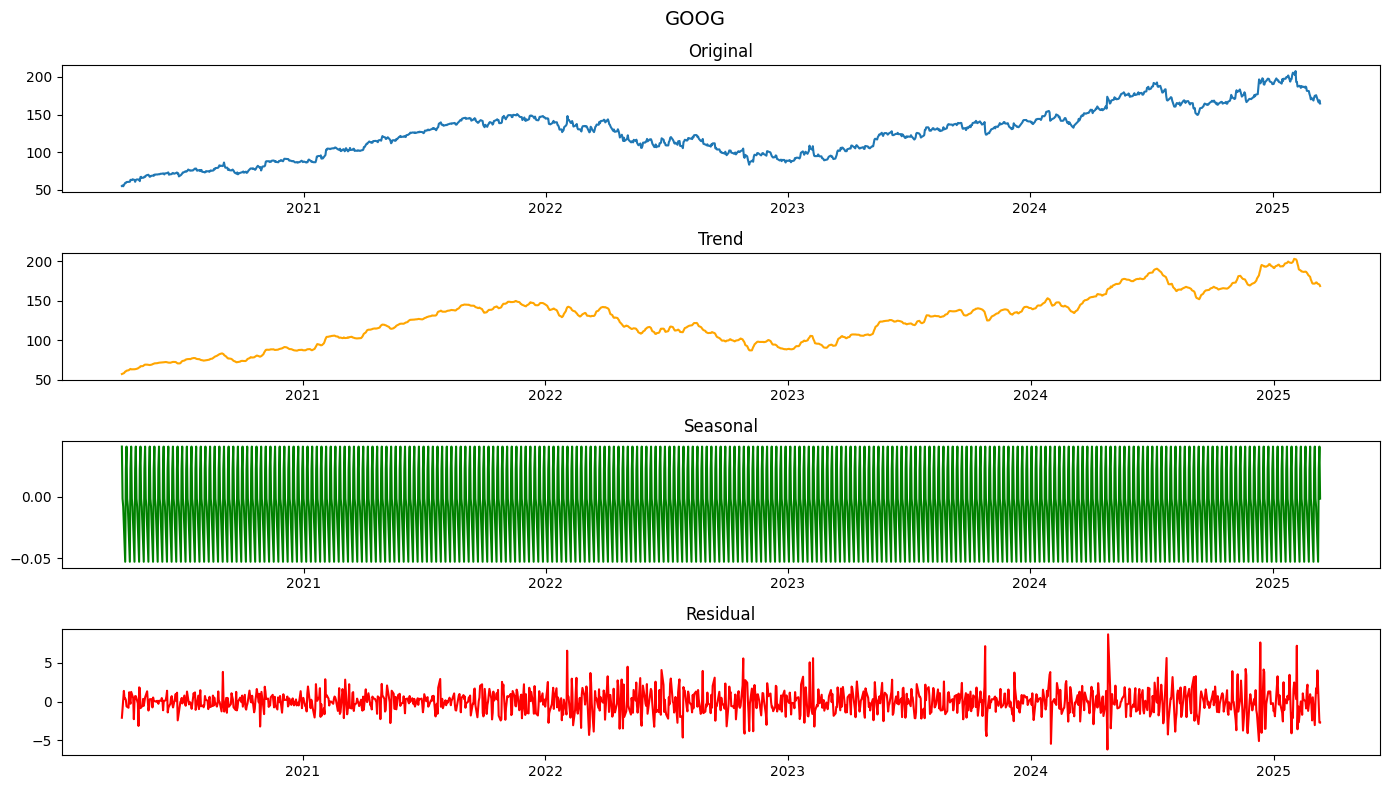

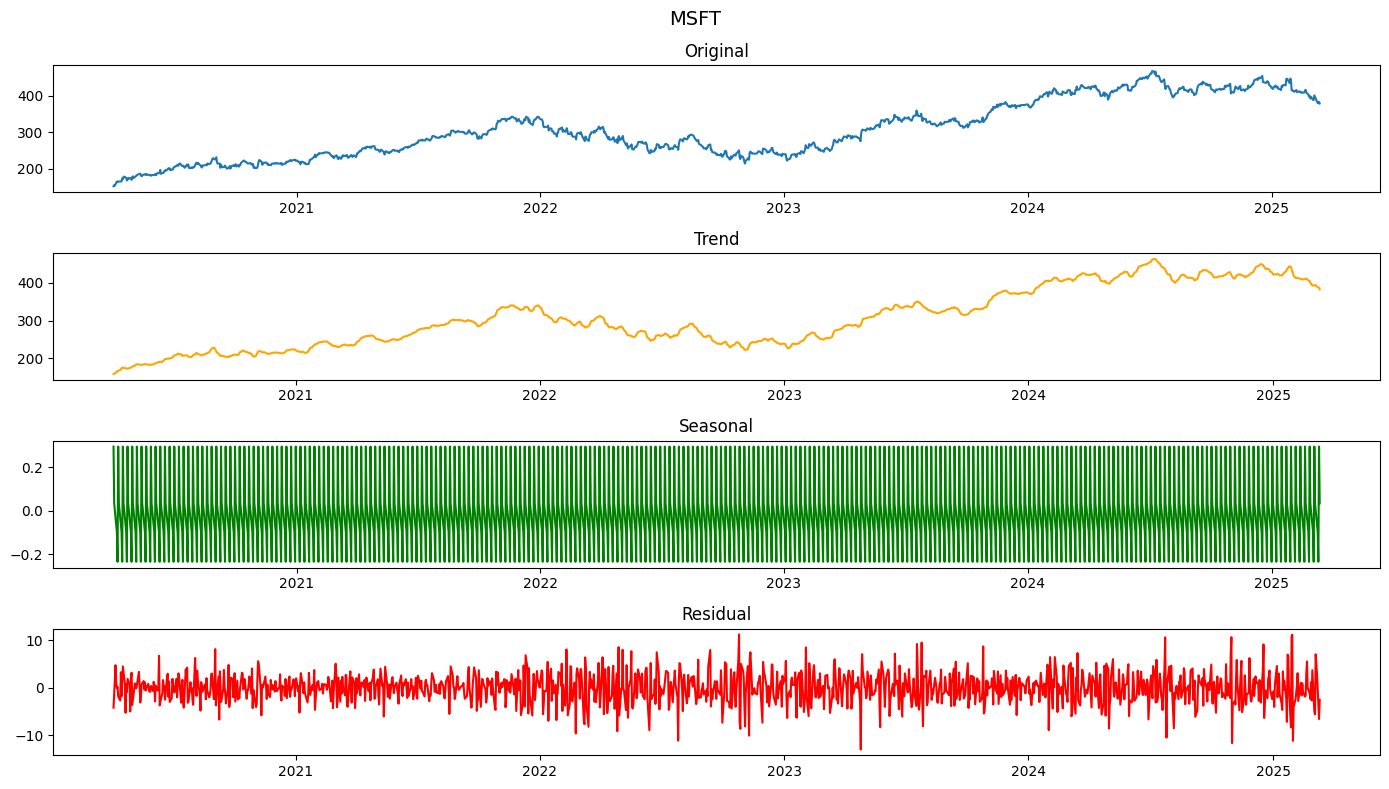

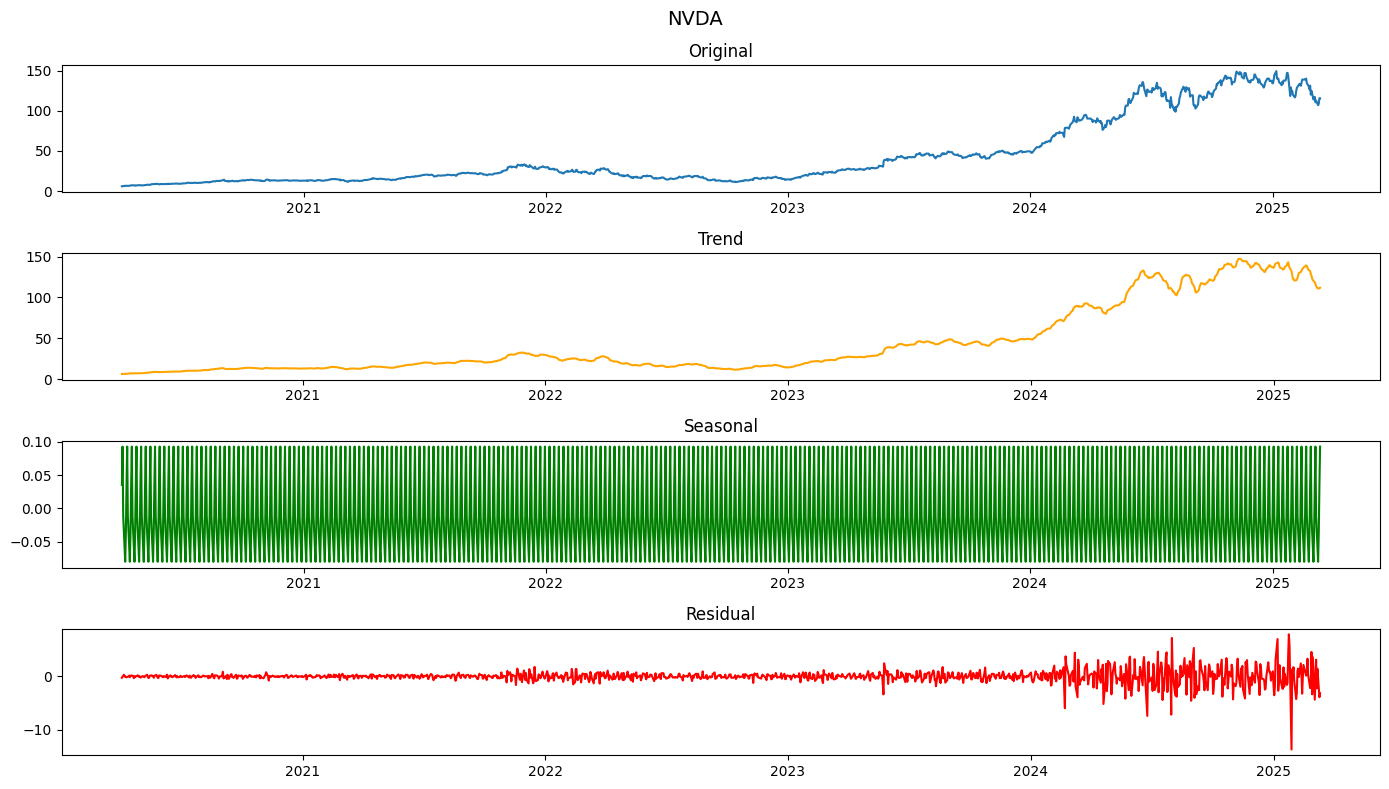

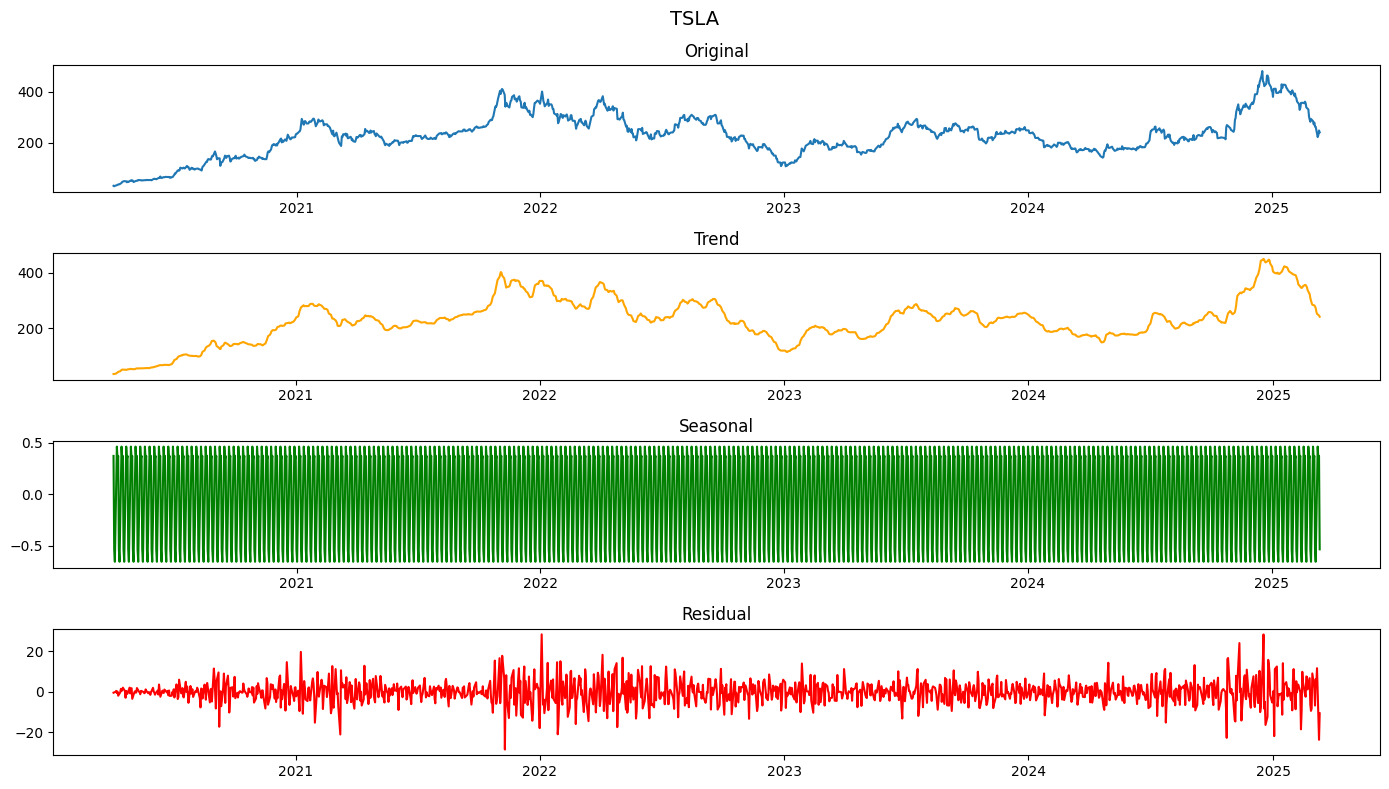

In [12]:
for ticker, decomp in ticker_decomps.items():
    plot_decomp(decomp, ticker)